In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier


import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_csv('./mhDataset.csv', index_col=0)

In [ ]:
df.dropna(inplace = True)

In [ ]:
import nltk
nltk.download('punkt_tab')
# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)
df['statement']=df['original_statement'].str.lower()

In [ ]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)

In [ ]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)

In [ ]:
lemmatizer=WordNetLemmatizer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(lemmatizer.lemmatize(token,pos="v") for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

In [ ]:
df['status'].value_counts()

,count
status,
Normal,16343
Depression,15404
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


In [ ]:
from collections import Counter

class_counts = {
    'Depression':15404,
    'Normal': 16343,
    'Anxiety': 3841,
    'Bipolar': 2777,
    'Stress': 2587,
    'Personality disorder': 1077
}

total_samples = sum(class_counts.values())
num_classes = len(class_counts)

class_weights = {
    cls: total_samples / (num_classes * count)
    for cls, count in class_counts.items()
}

print(class_weights)

{'Depression': 0.4547411927637843, 'Normal': 0.42861367761936814, 'Anxiety': 1.8237004252364835, 'Bipolar': 2.5224462849597886, 'Stress': 2.707705192629816, 'Personality disorder': 6.504023522129372}


In [ ]:
# 1. Keyword Features (Example keywords - this would be refined based on analysis)
keywords_depression = ['sad', 'depressed', 'hopeless', 'empty', 'cry', 'alone', 'down']
keywords_anxiety = ['anxious', 'worry', 'nervous', 'panic', 'fear', 'stress', 'overthinking']

def keyword_count(text, keywords):
    return sum(text.lower().count(keyword) for keyword in keywords)

df['keyword_depression'] = df['statement'].apply(lambda x: keyword_count(x, keywords_depression))
df['keyword_anxiety'] = df['statement'].apply(lambda x: keyword_count(x, keywords_anxiety))

# 2. Sentiment Analysis using TextBlob
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['sentiment_polarity'] = df['statement'].apply(get_sentiment)

# 3. Vocabulary Diversity (Type-Token Ratio)
def type_token_ratio(text):
    tokens = word_tokenize(text.lower())
    if not tokens:
        return 0
    return len(set(tokens)) / len(tokens)

df['type_token_ratio'] = df['statement'].apply(type_token_ratio)

# 4. Add new features to the feature set X
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences', 'keyword_depression', 'keyword_anxiety', 'sentiment_polarity', 'type_token_ratio']]

# Display the first few rows with the new features
display(X.head())

,tokens_stemmed,num_of_characters,num_of_sentences,keyword_depression,keyword_anxiety,sentiment_polarity,type_token_ratio
Unnamed: 0,,,,,,,
0,oh my gosh,10,1,0,0,0.0000,1.000000
1,trouble sleep confuse mind restless heart all ...,64,2,0,0,-0.3000,1.000000
2,all wrong back off dear forward doubt stay in ...,78,2,0,0,-0.2500,0.928571
3,ive shift my focus to something else but im st...,61,1,0,0,0.0000,1.000000
4,im restless and restless its be a month now bo...,72,2,0,0,-0.3125,0.928571


In [ ]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences', 'keyword_depression', 'keyword_anxiety', 'sentiment_polarity', 'type_token_ratio']]
y = df['status']

In [ ]:
# Define lists of keywords for 'Bipolar', 'Stress', and 'Personality disorder' classes
keywords_bipolar = ['bipolar', 'mania', 'manic', 'depressive', 'mood swing']
keywords_stress = ['stress', 'work', 'job', 'pressure', 'cope', 'handle']
keywords_personality_disorder = ['people', 'avpd', 'talk', 'social', 'relationship', 'borderline']
keywords_depression=['help', 'really', 'depression', 'work']
keywords_anxiety = ['anxious', 'worry', 'nervous', 'panic', 'fear', 'stress', 'overthinking']

# Create a function that takes text and a list of keywords as input and returns the total count of those keywords in the text
def keyword_count_class(text, keywords):
    return sum(text.lower().count(keyword) for keyword in keywords)

# Apply the keyword_count_class function to the 'statement' column to create new columns
df['keyword_bipolar'] = df['statement'].apply(lambda x: keyword_count_class(x, keywords_bipolar))
df['keyword_stress'] = df['statement'].apply(lambda x: keyword_count_class(x, keywords_stress))
df['keyword_personality_disorder'] = df['statement'].apply(lambda x: keyword_count_class(x, keywords_personality_disorder))
df['keyword_depression']=df['statement'].apply(lambda x: keyword_count_class(x, keywords_depression))
df['keyword_anxiety']=df['statement'].apply(lambda x: keyword_count_class(x, keywords_anxiety))

# Display the first few rows with the new keyword features
display(df[['original_statement', 'statement', 'keyword_bipolar', 'keyword_stress', 'keyword_personality_disorder','keyword_depression','keyword_anxiety']].head())

,original_statement,statement,keyword_bipolar,keyword_stress,keyword_personality_disorder,keyword_depression,keyword_anxiety
Unnamed: 0,,,,,,,
0,oh my gosh,oh my gosh,0,0,0,0,0
1,"trouble sleeping, confused mind, restless hear...",trouble sleeping confused mind restless heart ...,0,0,0,0,0
2,"All wrong, back off dear, forward doubt. Stay ...",all wrong back off dear forward doubt stay in ...,0,0,0,0,0
3,I've shifted my focus to something else but I'...,ive shifted my focus to something else but im ...,0,0,0,0,0
4,"I'm restless and restless, it's been a month n...",im restless and restless its been a month now ...,0,0,0,0,0


In [ ]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences', 'keyword_depression', 'keyword_anxiety', 'sentiment_polarity', 'type_token_ratio', 'keyword_bipolar', 'keyword_stress', 'keyword_personality_disorder']]

display(X.head())

,tokens_stemmed,num_of_characters,num_of_sentences,keyword_depression,keyword_anxiety,sentiment_polarity,type_token_ratio,keyword_bipolar,keyword_stress,keyword_personality_disorder
Unnamed: 0,,,,,,,,,,
0,oh my gosh,10,1,0,0,0.0000,1.000000,0,0,0
1,trouble sleep confuse mind restless heart all ...,64,2,0,0,-0.3000,1.000000,0,0,0
2,all wrong back off dear forward doubt stay in ...,78,2,0,0,-0.2500,0.928571,0,0,0
3,ive shift my focus to something else but im st...,61,1,0,0,0.0000,1.000000,0,0,0
4,im restless and restless its be a month now bo...,72,2,0,0,-0.3125,0.928571,0,0,0


In [ ]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [ ]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features (including the new ones)
X_train_num = X_train[['num_of_characters', 'num_of_sentences', 'keyword_depression', 'keyword_anxiety','keyword_bipolar','keyword_stress','keyword_personality_disorder', 'sentiment_polarity', 'type_token_ratio']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences', 'keyword_depression', 'keyword_anxiety','keyword_bipolar','keyword_stress','keyword_personality_disorder', 'sentiment_polarity', 'type_token_ratio']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [ ]:
# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

In [ ]:
# Calculate sample weights based on the class_weights dictionary and the resampled training labels

# Manually map the encoded integer labels back to their original string labels
original_labels_resampled = lbl_enc.classes_[y_train_resampled]

# Use the original labels to look up class weights
sample_weights = np.array([class_weights[label] for label in original_labels_resampled])

print("Sample weights calculated successfully.")

Sample weights calculated successfully.


In [ ]:
best_params_lgbm = {'learning_rate': 0.1, 'n_estimators': 300, 'num_leaves': 62}
# Define your models
models = {
    'LightGBM': LGBMClassifier(
        random_state=101,
        objective='multiclass',
        num_class=6,
        **best_params_lgbm
    )
}

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 41.029562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 678199
[LightGBM] [Info] Number of data points in the train set: 78180, number of used features: 34491
[LightGBM] [Info] Start training from score -2.069220
[LightGBM] [Info] Start training from score -1.744858
[LightGBM] [Info] Start training from score -3.458114
[LightGBM] [Info] Start training from score -3.517287
[LightGBM] [Info] Start training from score -0.797666
[LightGBM] [Info] Start training from score -1.673986


For LightGBM
Accuracy: 0.9018558172733762
                      precision    recall  f1-score   support

             Anxiety       0.85      0.84      0.84       790
             Bipolar       0.88      0.84      0.86       543
          Depression       0.94      0.93      0.94      3014
              Normal       0.94      0.93      0.94      3313
Personality disorder      

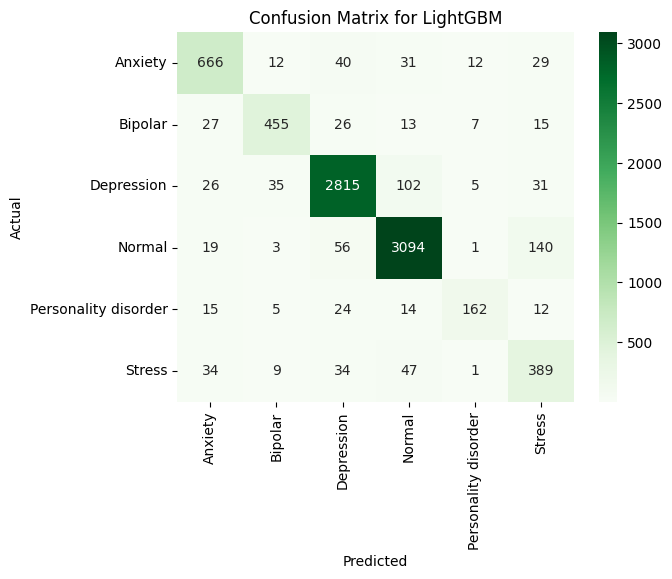

In [ ]:
# Initialize a list to store accuracy scores for each classifier
accuracy_scores = []

# Iterate over each classifier and its name in the models dictionary
for name, clf in models.items():
    # Fit the model with the calculated sample weights
    clf.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)
    y_pred = clf.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)

    print("\n")
    print("For", name)
    print("Accuracy:", accuracy)

    # Compute the confusion matrix for the predictions
    labels = lbl_enc.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=labels))

    # Plot the confusion matrix using a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # Append the accuracy score to the list
    accuracy_scores.append(accuracy)


Evaluating LightGBM with best hyperparameters...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 82.172011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1312140
[LightGBM] [Info] Number of data points in the train set: 78180, number of used features: 44841
[LightGBM] [Info] Start training from score -2.069220
[LightGBM] [Info] Start training from score -1.744858
[LightGBM] [Info] Start training from score -3.458114
[LightGBM] [Info] Start training from score -3.517287
[LightGBM] [Info] Start training from score -0.797666
[LightGBM] [Info] Start training from score -1.673986

Evaluation of LightGBM with best hyperparameters:
Accuracy: 0.9091125386628599
                      precision    recall  f1-score   support

             Anxiety       0.84      0.87      0.85       790
             Bipolar       0.88      0.84      0.86       543
          Depression       0.95      0.94      0.94      3014
 

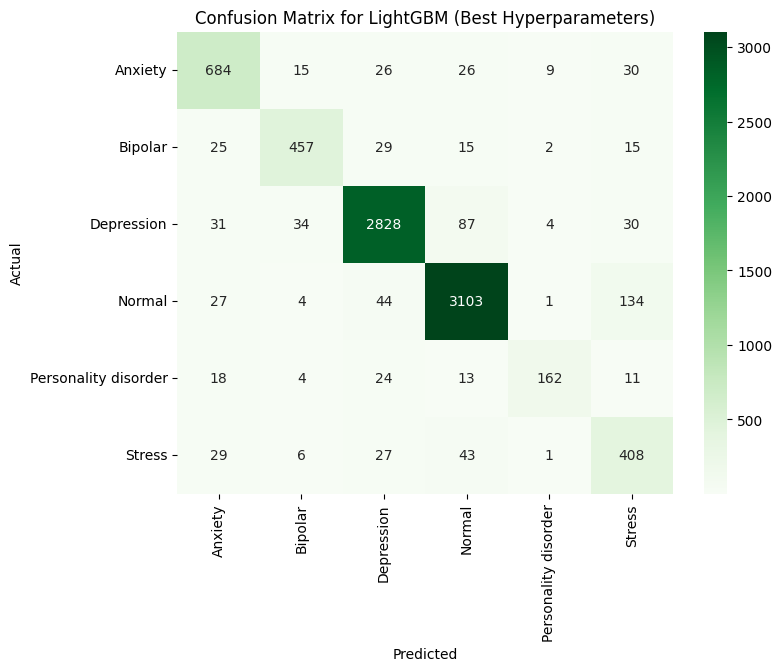

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Best hyperparameters found in the previous run
best_params_xgb = {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
best_params_lgbm = {'learning_rate': 0.1, 'n_estimators': 300, 'num_leaves': 62}

# 6. Evaluate the models with the best hyperparameters on the test set
# print("\nEvaluating XGBoost with best hyperparameters...")
# best_xgb_model = XGBClassifier(random_state=101, tree_method='gpu_hist', objective='multi:softprob', num_class=6, **best_params_xgb)
# best_xgb_model.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)
# y_pred_xgb = best_xgb_model.predict(X_test_combined)
# accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# print("\nEvaluation of XGBoost with best hyperparameters:")
# print("Accuracy:", accuracy_xgb)
labels = lbl_enc.classes_
# print(classification_report(y_test, y_pred_xgb, target_names=labels))

print("\nEvaluating LightGBM with best hyperparameters...")
best_lgbm_model = LGBMClassifier(random_state=101, objective='multiclass', num_class=6, **best_params_lgbm)
best_lgbm_model.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)
y_pred_lgbm = best_lgbm_model.predict(X_test_combined)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)

print("\nEvaluation of LightGBM with best hyperparameters:")
print("Accuracy:", accuracy_lgbm)
print(classification_report(y_test, y_pred_lgbm, target_names=labels))

# 7. Visualize the confusion matrices for the models with the best hyperparameters
print("\nPlotting confusion matrices...")

# Confusion Matrix for XGBoost
# conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix for XGBoost (Best Hyperparameters)')
# plt.show()

# Confusion Matrix for LightGBM
conf_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lgbm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LightGBM (Best Hyperparameters)')
plt.show()

In [ ]:
def preprocess_input(text, vectorizer, lbl_enc, keywords_depression, keywords_anxiety, keywords_bipolar, keywords_stress, keywords_personality_disorder):
    # Apply the same preprocessing steps as used for the training data

    # 1. Lowercase and remove patterns
    cleaned_text = remove_patterns(text.lower())

    # 2. Tokenization
    tokens = word_tokenize(cleaned_text)

    # 3. Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens_stemmed = ' '.join(lemmatizer.lemmatize(token, pos="v") for token in tokens)

    # 4. Feature Engineering (Basic)
    num_of_characters = len(text)
    num_of_sentences = len(nltk.sent_tokenize(text))

    # 5. Feature Engineering (Advanced) - Keyword Counts
    keyword_depression = keyword_count_class(cleaned_text, keywords_depression)
    keyword_anxiety = keyword_count_class(cleaned_text, keywords_anxiety)
    keyword_bipolar = keyword_count_class(cleaned_text, keywords_bipolar)
    keyword_stress = keyword_count_class(cleaned_text, keywords_stress)
    keyword_personality_disorder = keyword_count_class(cleaned_text, keywords_personality_disorder)

    # 6. Feature Engineering (Advanced) - Sentiment Analysis
    sentiment_polarity = TextBlob(cleaned_text).sentiment.polarity

    # 7. Feature Engineering (Advanced) - Vocabulary Diversity
    type_token_ratio_val = type_token_ratio(cleaned_text)

    # 8. TF-IDF Transformation
    tfidf_features = vectorizer.transform([tokens_stemmed])

    # 9. Combine TF-IDF and numerical features
    numerical_features = np.array([[num_of_characters, num_of_sentences, keyword_depression, keyword_anxiety,
                                    keyword_bipolar, keyword_stress, keyword_personality_disorder,
                                    sentiment_polarity, type_token_ratio_val]])
    combined_features = hstack([tfidf_features, numerical_features])

    return combined_features

# Take user input
user_input = input("Enter the statement: ")

# Preprocess the user input
processed_input = preprocess_input(user_input, vectorizer, lbl_enc, keywords_depression, keywords_anxiety, keywords_bipolar, keywords_stress, keywords_personality_disorder)

# Make prediction using the trained LightGBM model
prediction = best_lgbm_model.predict(processed_input)

# Decode the prediction
predicted_label = lbl_enc.inverse_transform(prediction)

print("\nPredicted Mental Health Status:", predicted_label[0])

Enter the statement: I want to die

Predicted Mental Health Status: Normal


In [ ]:
import joblib

# Save the trained LightGBM model
joblib.dump(best_lgbm_model, 'lgbm_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, 'lgbm_tfidf_vectorizer.pkl')

# Save the label encoder
joblib.dump(lbl_enc, 'lgbm_label_encoder.pkl')

print("Model, vectorizer, and label encoder saved successfully.")

Model, vectorizer, and label encoder saved successfully.


In [ ]:
from google.colab import files

# Download the saved files
files.download('lgbm_model.pkl')
files.download('lgbm_tfidf_vectorizer.pkl')
files.download('lgbm_label_encoder.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>